In [1]:
from chebGreen.greenlearning.model import *
from chebGreen.chebpy2 import Chebfun2, Chebpy2Preferences
import matplotlib.pyplot as plt

# %env TF_MLC_LOGGING=1
# %env TF_CPP_MIN_LOG_LEVEL=2

In [2]:
theta = 1.0

In [3]:
model = GreenNN()
dimension = 1
domain = [-1,1,-1,1]
layerConfig = [50,50,50,50]
activation = 'rational'
dirichletBC = False
loadPath = f'savedModels/mean_condition/{theta:.2f}'
model.build(dimension, domain, layerConfig, activation, dirichletBC, loadPath)

In [4]:
%%time
cheb2prefs = Chebpy2Preferences()
# cheb2prefs.prefx.eps = 1e-8
# cheb2prefs.prefx.eps = 1e-8
g = Chebfun2(model.evaluateG, domain = domain, prefs = cheb2prefs, simplify = False)

CPU times: user 325 ms, sys: 77.4 ms, total: 403 ms
Wall time: 430 ms


In [5]:
g

chebfun2 object
     domain       rank               corner values
[-1,1] x [-1,1]     65       [0.005 0.003 0.000 0.010]
vertical scale = 0.492073

In [6]:
# u,s,v = g.svd()

In [7]:
# # i = slice(10,20)
# j = 0
# i = slice(j,j+1)
# # i = 16
# fig = plt.figure(figsize = (8,6))
# u[:,i].plot(fig = fig)
# # print(np.max(u[:,i].vscale))
# # plt.title(f'Firstx {i+1} left singular functions for a Laplacian')
# plt.xlim([-1,1])
# # fig.savefig(f'Laplace-first.png', dpi = fig.dpi)

In [8]:
# plt.figure()
# plt.semilogy(s)

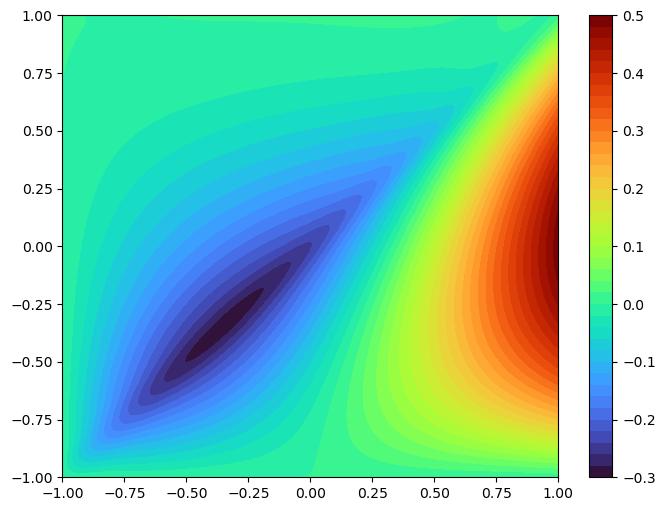

In [9]:
fig = plt.figure(figsize = (8,6))
g.plot(fig = fig)

In [10]:
from chebGreen.greenlearning.utils import DataProcessor
from chebGreen.utils import vec2cheb
from chebGreen.chebpy2.chebpy.api import chebfun
from chebGreen.chebpy2.chebpy.core.settings import ChebPreferences
from chebGreen.chebpy2 import Quasimatrix

In [11]:
data = DataProcessor(f'datasets/mean_condition/{theta:.2f}')
data.generateDataset(trainRatio = 0.95)

In [37]:
def computeEmpiricalError(data):
    Error, UC, U0, F0 = [],[],[],[]
    for i in range(data.valDataset[1].cpu().numpy().shape[0]):
        #     continue
        xF, xU = data.xF, data.xU
        f, u  = data.valDataset[0].cpu().numpy()[i,:], data.valDataset[1].cpu().numpy()[i,:]
        f0, u0 = vec2cheb(f,xF), vec2cheb(u,xU)

        prefs = ChebPreferences()
        prefs.eps = 1e-12
        un = chebfun(lambda x: model.evaluateN(x), domain = f0.domain, prefs = prefs)
        uc = g.T.integralTransform(f0) + un
        error = (uc - u0).abs()
        Error.append(error)
        UC.append(uc)
        U0.append(u0)
        F0.append(f0)
    return Error, UC, U0, F0, un

In [38]:
%%time
Error, UC, Response, Forcing, un = computeEmpiricalError(data)

CPU times: user 9.02 s, sys: 26.5 s, total: 35.5 s
Wall time: 5.67 s


In [39]:
%%time
e = 0
for error,u0 in zip(Error,Response):
    e += error.sum()/(u0+un).abs().sum()
e /= len(Error)

CPU times: user 1.72 s, sys: 1.64 ms, total: 1.72 s
Wall time: 1.72 s


<Axes: >

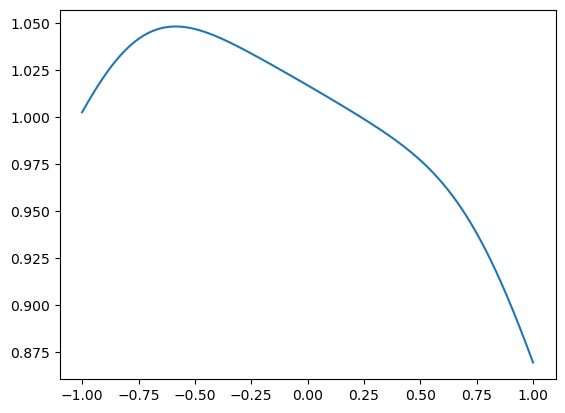

In [41]:
un.plot()

In [17]:
print(f"Percentage relative error = {np.mean(e)*100}%")

Percentage relative error = 0.020386715754574708%


(-1.0, 1.0)

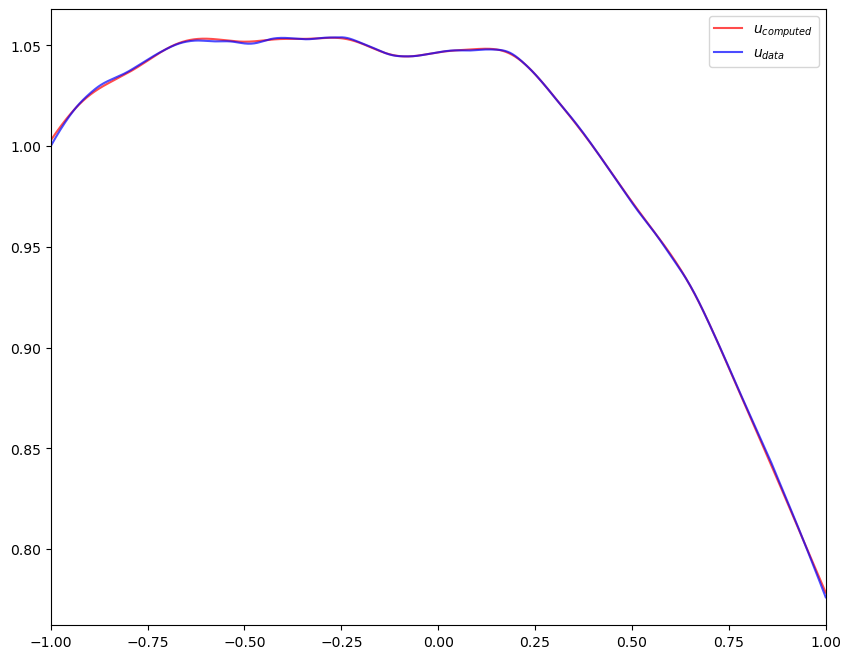

In [18]:
i = 5
error,uc,u0 = Error[i],UC[i],Response[i]
fig = plt.figure(figsize = (10,8))
(uc).plot(fig = fig, color = 'red',linestyle ='-', alpha = 0.7)
(u0).plot(fig = fig, color = 'blue',linestyle ='-', alpha = 0.7)
# (uc-u0).plot(fig = fig, color = 'green',linestyle ='--', alpha = 0.7)
plt.legend(['$u_{{computed}}$',f'$u_{{data}}$'])
plt.xlim([u0.domain[0],u0.domain[1]])
# plt.title(f'Relative Error = {error.sum()/u0.abs().sum():}')

Text(0.5, 1.0, 'Relative Error = 0.00042375308158919365')

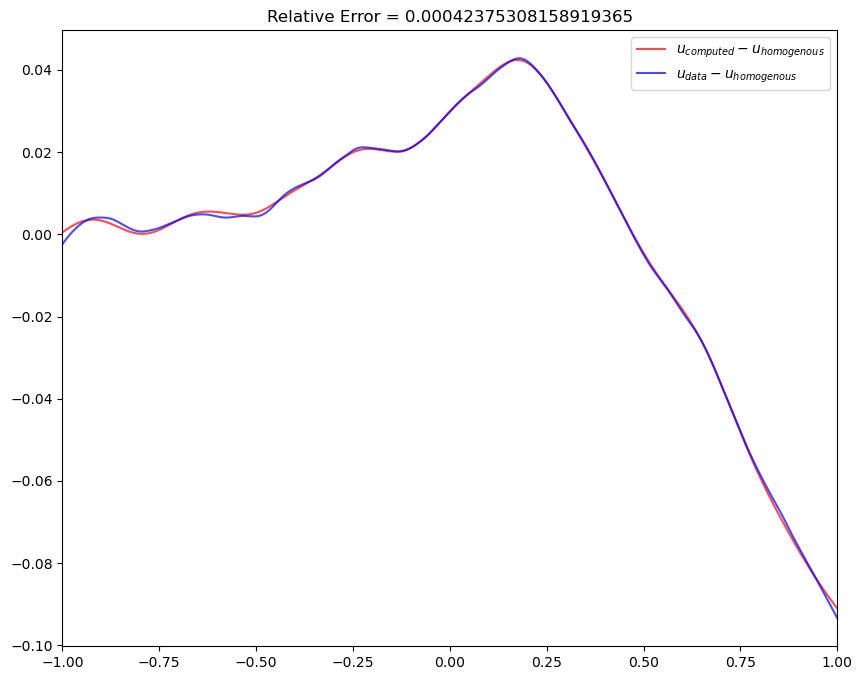

In [19]:
i = 5
error,uc,u0 = Error[i],UC[i],Response[i]
fig = plt.figure(figsize = (10,8))
(uc-un).plot(fig = fig, color = 'red',linestyle ='-', alpha = 0.7)
(u0-un).plot(fig = fig, color = 'blue',linestyle ='-', alpha = 0.7)
# (uc-u0).plot(fig = fig, color = 'green',linestyle ='--', alpha = 0.7)
plt.legend(['$u_{{computed}} - u_{{homogenous}}$',f'$u_{{data}} - u_{{homogenous}}$'])
plt.xlim([u0.domain[0],u0.domain[1]])
plt.title(f'Relative Error = {error.sum()/u0.abs().sum():}')